----
## **<font color="crimson"> El otro 914 está más ordenado </font>**

----
## **<font color="crimson"> Actualizar base de datos de ERA5 de temperatura </font>**

### **<font color="crimson"> Nuevos CAO de ERA5: promedios,anomalías, dataframe.. </font>**

In [1]:
pip install cartopy

  Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install h5netcdf 

  Using cached h5netcdf-1.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached h5py-3.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.7 kB)
Using cached h5netcdf-1.6.1-py3-none-any.whl (49 kB)
Using cached h5py-3.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install toolz

Note: you may need to restart the kernel to use updated packages.


In [10]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import math
import cftime
from collections import Counter
import matplotlib.patches as patches

### **<font color="RoyalBlue"> Flujo general de análisis </font>**

1. Lectura de datos.
2. Selección de datos de invierno.
3. Cálculo de temperatura promedio y desviación estándar móvil.
4. Cálculo de anomalías
5. Código de CAOs
6. Gráficos y visualización. 

### **<font color="Purple"> Datos de HadGEM3 [1] </font>**

### **<font color="olive"> Temperatura </font>**

In [11]:
tas_file = 'datasetsok/tasday79.nc'

In [12]:
#archivo historical
tas_ds=xr.open_dataset(tas_file)
tas=tas_ds['tas']

In [13]:
tas_inviernos = tas.sel(time=tas['time.month'].isin([12, 1, 2]))

##### Para promedios móviles 

2. Selección de datos de invierno

In [14]:
regionHG = tas_inviernos.sel(lat=slice(5, 50), lon=slice(227,297)) #solo djf, meses 1,2,12 

In [15]:
tas_climyear = regionHG.groupby('time.year').mean('time')

In [16]:
tasclimyearsuav = tas_climyear.rolling(year=20, center=True, min_periods=15).mean()

In [17]:
tas_climyearstd = regionHG.groupby('time.year').std('time')
tas_std = regionHG.std('time')

In [18]:
tassuavstd = tas_climyearstd.rolling(year=20, center=True, min_periods=15).mean()

La función siguiente la hicimos para calcular bien la desviación estándar en una ventana de 20 años, que no es lo mismo que calcular la desviación estándar anual y promediarla en 20 años, que es lo que hacíamos antes. 

In [19]:
def rolling_pooled_std(da, window=20, min_periods=None):
    """
    Compute a rolling (moving window) pooled standard deviation of daily data.
    
    For each central year, this function pools all available data in a window 
    of years (default 20 years) and computes the standard deviation along the time dimension.
    
    Parameters:
      da (xr.DataArray): Daily data with a 'time' coordinate.
      window (int): Number of years for the moving window.
      min_periods (int): Minimum number of years required in a window to compute std.
                         Defaults to half the window if not provided.
    
    Returns:
      xr.DataArray: A DataArray of pooled standard deviations computed for each central year.
    """
    if min_periods is None:
        min_periods = window // 2

    # Get unique years from the time coordinate.
    unique_years = np.sort(np.unique(da.time.dt.year.values))
    std_values = []
    std_years = []

    half_window = window // 2
    for y in unique_years:
        window_start = y - half_window
        window_end = y + half_window
        # Select data within the window.
        window_data = da.sel(time=((da.time.dt.year >= window_start) & (da.time.dt.year <= window_end)))
        # Count unique years in the window using np.unique.
        if len(np.unique(window_data.time.dt.year.values)) >= min_periods:
            pooled_std = window_data.std(dim='time')
            std_values.append(pooled_std)
            std_years.append(y)
            
    # Concatenate along a new 'year' dimension.
    pooled_std_da = xr.concat(std_values, dim='year')
    pooled_std_da = pooled_std_da.assign_coords(year=('year', std_years))
    
    return pooled_std_da

# Example usage:
# Assuming 'regionHG' is your daily DJF DataArray (temperature data for your region)
tas_rolling_std = rolling_pooled_std(regionHG, window=25, min_periods=10)


In [20]:
tas_rolling_std

<xarray.DataArray 'tas' (year: 36, lat: 36, lon: 37)> Size: 192kB
array([[[0.67063594, 0.66779566, 0.6874562 , ..., 1.2618604 ,
         1.3788084 , 1.0318592 ],
        [0.5689685 , 0.56990576, 0.5757498 , ..., 1.3403523 ,
         1.284568  , 1.5249009 ],
        [0.557692  , 0.54649603, 0.5321386 , ..., 1.1223625 ,
         1.0181675 , 1.053668  ],
        ...,
        [2.186476  , 2.219865  , 2.260973  , ..., 8.4484    ,
         8.4544    , 6.803953  ],
        [2.3152926 , 2.3564227 , 2.4116411 , ..., 8.936397  ,
         8.877634  , 6.8967    ],
        [2.5090744 , 2.5848124 , 2.8309324 , ..., 9.108329  ,
         9.470786  , 7.0018425 ]],

       [[0.6597884 , 0.6581344 , 0.67609435, ..., 1.245501  ,
         1.3531032 , 1.0128436 ],
        [0.5612176 , 0.5625529 , 0.5659228 , ..., 1.3254256 ,
         1.2757388 , 1.5104103 ],
        [0.54849476, 0.5368525 , 0.52271855, ..., 1.1062846 ,
         1.0164568 , 1.0521227 ],
...
        [2.2790892 , 2.3137236 , 2.323248  , ..., 8.178325  ,
         8.03942   , 6.117432  ],
        [2.3813035 , 2.4281795 , 2.4493663 , ..., 8.817407  ,
         8.484471  , 6.0755014 ],
        [2.534967  , 2.5983584 , 2.822661  , ..., 9.167574  ,
         9.234728  , 6.2406783 ]],

       [[0.8753945 , 0.84502405, 0.8298451 , ..., 1.4088345 ,
         1.6081159 , 1.2975096 ],
        [0.749589  , 0.7341753 , 0.7278584 , ..., 1.5389925 ,
         1.5386119 , 1.7503633 ],
        [0.68569905, 0.6769835 , 0.67105556, ..., 1.3098408 ,
         1.1731265 , 1.3131366 ],
        ...,
        [2.238838  , 2.2824852 , 2.305113  , ..., 8.107134  ,
         7.975108  , 6.059888  ],
        [2.3480828 , 2.407133  , 2.4384465 , ..., 8.767545  ,
         8.498428  , 6.0283356 ],
        [2.5054765 , 2.583441  , 2.8246827 , ..., 9.154065  ,
         9.250608  , 6.217689  ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 296B 227.8 229.7 231.6 233.4 ... 291.6 293.4 295.3
  * lat      (lat) float64 288B 5.625 6.875 8.125 9.375 ... 46.88 48.12 49.38
    height   float64 8B 1.5
  * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014

##### Climatología diaria

In [21]:
regionHG = tas.sel(lat=slice(5, 50), lon=slice(227,297))

In [22]:
tas_climday = regionHG.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

In [23]:
tasclimdaysuav = tas_climday.rolling(dayofyear=7, center=True, min_periods=1).mean()

In [24]:
anomaliasday = regionHG.groupby('time.dayofyear') - tasclimdaysuav 

In [25]:
anomaliasday

<xarray.DataArray 'tas' (time: 12960, lat: 36, lon: 37)> Size: 69MB
array([[[-1.1516762e+00, -9.3667984e-01, -1.0647697e+00, ...,
         -1.1023407e+00, -1.0235119e+00, -1.1688576e+00],
        [-1.0503387e+00, -1.0603256e+00, -1.1090317e+00, ...,
         -1.3307018e+00, -1.3091717e+00, -2.1103783e+00],
        [-9.1085815e-01, -8.8836479e-01, -9.5156479e-01, ...,
         -1.3785686e+00, -1.5226536e+00, -1.1761131e+00],
        ...,
        [-3.0614347e+00, -2.8315067e+00, -2.0697880e+00, ...,
         -7.8421326e+00, -7.1442747e+00, -7.7928467e+00],
        [-3.1734433e+00, -2.6508412e+00, -1.7684193e+00, ...,
         -7.3497009e+00, -5.0054245e+00, -7.9081302e+00],
        [-2.9367509e+00, -2.1898212e+00, -1.6750588e+00, ...,
         -5.8792229e+00, -4.6557808e+00, -7.4420719e+00]],

       [[-1.1403770e+00, -8.9331436e-01, -8.9745522e-01, ...,
         -1.2655373e+00, -9.7762489e-01, -1.0689182e+00],
        [-1.1822357e+00, -9.4765854e-01, -1.1434021e+00, ...,
         -1.2453804e+00, -9.3978500e-01, -1.6497440e+00],
        [-1.4908199e+00, -1.5916405e+00, -1.4043388e+00, ...,
         -1.4141731e+00, -5.0864601e-01, -5.9996605e-01],
...
        [-5.1438904e-01, -4.8655891e-01, -7.9429626e-01, ...,
          1.1548591e+01,  1.1721748e+01,  8.6262512e+00],
        [-5.6466198e-01, -7.2881222e-01, -9.0392208e-01, ...,
          1.5059477e+01,  1.5349750e+01,  9.2395668e+00],
        [-7.2208118e-01, -1.0966258e+00, -1.4707742e+00, ...,
          1.9404390e+01,  1.9160589e+01,  1.0567413e+01]],

       [[ 1.5145226e+00,  1.5778809e+00,  1.5070648e+00, ...,
          1.0749626e+00,  2.2195091e+00,  9.3640518e-01],
        [ 1.2549591e+00,  1.1976337e+00,  1.1695805e+00, ...,
          2.4984398e+00,  2.7691212e+00,  2.7930489e+00],
        [ 8.3588219e-01,  9.2862320e-01,  9.6240234e-01, ...,
          2.7325592e+00,  2.5886078e+00,  2.4009304e+00],
        ...,
        [-1.3665209e+00, -1.4087925e+00,  1.4506435e-01, ...,
          6.4258280e+00,  6.0385075e+00,  3.9361563e+00],
        [-5.1059723e-02, -1.0149460e+00, -7.9614830e-01, ...,
          9.9619446e+00,  9.3631420e+00,  4.3953710e+00],
        [-2.9885292e-02, -8.5105896e-01, -8.8782310e-01, ...,
          1.3148132e+01,  1.3518234e+01,  6.3786955e+00]]], dtype=float32)
Coordinates:
  * time       (time) object 104kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lon        (lon) float64 296B 227.8 229.7 231.6 233.4 ... 291.6 293.4 295.3
  * lat        (lat) float64 288B 5.625 6.875 8.125 9.375 ... 46.88 48.12 49.38
    height     (time) float64 104kB 1.5 1.5 1.5 1.5 1.5 ... 1.5 1.5 1.5 1.5 1.5
    dayofyear  (time) int64 104kB 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360

### **<font color="red"> 4. Anomalías </font>**

El siguiente código quita la tendencia de largo plazo (la señal del cambio climático) de las anomalías. 

In [26]:
def detrend_dataarray_preserve_mean(da, dim='time'):
    """
    Remove the linear trend (slope) along the specified dimension from an xarray DataArray,
    while preserving the original mean of the data.

    Parameters:
      da (xr.DataArray): The input data array.
      dim (str): The dimension along which to detrend (default is 'time').

    Returns:
      xr.DataArray: The detrended data array with the original mean preserved.
    """
    # Convert time coordinate to numeric values.
    if isinstance(da[dim].values[0], cftime.datetime):
        try:
            calendar = da[dim].values[0].calendar
        except AttributeError:
            calendar = 'standard'
        units = "days since 2000-01-01"
        time_numeric_values = [cftime.date2num(t, units, calendar) for t in da[dim].values]
        time_numeric = xr.DataArray(time_numeric_values, dims=dim, coords={dim: da[dim]})
    else:
        time_numeric = xr.DataArray(
            da[dim].values.astype('float64'),
            dims=dim,
            coords={dim: da[dim]}
        )
    
    def detrend_1d_preserve_mean(y, x):
        # Fit a linear trend
        p = np.polyfit(x, y, 1)
        slope, intercept = p
        # Subtract only the slope * (x - mean(x)) to preserve the overall mean.
        return y - slope * (x - np.mean(x))
    
    detrended = xr.apply_ufunc(
        detrend_1d_preserve_mean,
        da,
        time_numeric,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[da.dtype]
    )
    
    return detrended

# Example usage:
# da_detrended = detrend_dataarray_preserve_mean(regionHG, dim='time')


Climatología diaria

In [27]:
# file_anomtas = 'datasetsok/anomalias_day_tasHG.nc'
# anom_tas = xr.open_dataset(file_anomtas)
# anomaliasday=anom_tas['tas']

In [28]:
anomaliasday_detrend = detrend_dataarray_preserve_mean(anomaliasday, dim='time') #aquí les está quitando la tendencia de CC a las anomalías

La siguiente es la celda que agregamos para que los objetos de anomalías y T absolutas tengan la misma forma. 

In [29]:
anomaliasday_detrend_djf=anomaliasday_detrend.sel(time=anomaliasday_detrend['time.month'].isin([12, 1, 2]))

### **<font color="olive"> Viento </font>**

In [30]:
file_uHG = 'datasetsok/uday_250hpa_HG_1979_2014.nc'

In [31]:
# Abrir archivos y seleccionar variables a usar 
u_dsHG=xr.open_dataset(file_uHG )
uHG=u_dsHG['ua']  

In [32]:
# u_seasonHG=uHG.groupby(uHG.time.dt.season).mean(dim='time') 
# u_DJFHG = u_seasonHG[0]

In [33]:
u_inviernosHG = uHG.sel(time=uHG ['time.month'].isin([12, 1, 2]))

##### Climatología diaria

In [34]:
file_anom_uHG = 'datasetsok/anomalias_day_uHG.nc'
anom_uHG = xr.open_dataset(file_anom_uHG)
anomaliasday_uHG=anom_uHG['ua']

In [35]:
# misma linea adicional importante, por eso cambiará el nombre del objeto abajo. 
uanomaliasday_djf=anomaliasday_uHG.sel(time=anomaliasday_uHG['time.month'].isin([12, 1, 2]))

### **<font color="Purple"> Datos de ERA-5 </font>**

### **<font color="olive"> Temperatura</font>**

In [36]:
filet2m_era5 = 'datasetsok/t2mC_1979_2024.nc'

In [37]:
t2m_ds=xr.open_dataset(filet2m_era5)
t2m=t2m_ds['t2m']

In [38]:
# t2m_anual = t2m.groupby(t2m.time.dt.year).mean(dim='time').mean(dim='year')
# # Calcular promedio estacional
# t2m_estacion=t2m.groupby(t2m.time.dt.season).mean(dim='time') 
# #seleccionar inviernos
# invs_E5 = t2m_estacion[0]

In [39]:
t2m_inviernos = t2m.sel(time=t2m['time.month'].isin([12, 1, 2]))

In [40]:
regionE5 = t2m_inviernos.sel(latitude=slice(50, 5), longitude=slice(-133,-63)) #solo djf, meses 1,2,12 

##### Para promedios móviles

Ciclo anual, desviación estándar y anomalías.

In [41]:
t2m_climyear = regionE5.groupby('time.year').mean('time')

In [42]:
t2mclimyearsuav = t2m_climyear.rolling(year=20, center=True, min_periods=15).mean()

In [43]:
t2m_climyearstd = regionE5.groupby('time.year').std('time')

In [44]:
t2msuavstd = t2m_climyearstd.rolling(year=20, center=True, min_periods=15).mean()

In [45]:
t2m_rolling_std = rolling_pooled_std(regionE5, window=20, min_periods=15) #desiación estándar móvil

In [46]:
t2m_rolling_std 

<xarray.DataArray 't2m' (year: 38, latitude: 41, longitude: 53)> Size: 330kB
array([[[3.6964953 , 4.7574644 , 4.751545  , ..., 5.4516826 ,
         5.4214334 , 5.4268723 ],
        [3.7788606 , 3.9932854 , 5.0306892 , ..., 6.1047606 ,
         6.298463  , 6.3523984 ],
        [3.3583007 , 4.2500043 , 4.200448  , ..., 6.172007  ,
         6.1860223 , 5.9165707 ],
        ...,
        [0.6240942 , 0.6117026 , 0.6010132 , ..., 0.642996  ,
         0.627299  , 0.5531826 ],
        [0.6198856 , 0.61383575, 0.61653006, ..., 0.61240137,
         0.67867327, 0.6621432 ],
        [0.6344772 , 0.62572837, 0.62292814, ..., 0.83036405,
         0.5744584 , 0.51708865]],

       [[3.5999663 , 4.6044407 , 4.6281233 , ..., 5.6356826 ,
         5.616692  , 5.6428075 ],
        [3.728094  , 3.961372  , 4.991823  , ..., 6.1547084 ,
         6.3386016 , 6.388189  ],
        [3.294871  , 4.200033  , 4.157571  , ..., 6.2123904 ,
         6.2176266 , 5.9509144 ],
...
        [0.71754336, 0.71374285, 0.70801353, ..., 0.7096808 ,
         0.6920388 , 0.66175735],
        [0.7158255 , 0.7198592 , 0.72195524, ..., 0.6242831 ,
         0.67186326, 0.66192544],
        [0.71670276, 0.7204851 , 0.7188103 , ..., 0.8471517 ,
         0.63253343, 0.5596739 ]],

       [[3.30509   , 4.156054  , 4.120697  , ..., 6.1826777 ,
         6.1598034 , 6.1577535 ],
        [3.5250082 , 4.0211773 , 5.081104  , ..., 6.1726007 ,
         6.2711573 , 6.2964144 ],
        [2.9904354 , 3.8854818 , 4.245428  , ..., 6.18367   ,
         6.1942787 , 5.9679527 ],
        ...,
        [0.72057486, 0.7187951 , 0.71288913, ..., 0.70026785,
         0.6870278 , 0.6582825 ],
        [0.7193872 , 0.72462004, 0.7253198 , ..., 0.60968524,
         0.6663044 , 0.66040677],
        [0.7197241 , 0.72206163, 0.7193988 , ..., 0.82709646,
         0.6176079 , 0.55168515]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 328B 39.0 38.25 37.5 36.75 ... 10.5 9.75 9.0
  * longitude  (longitude) float64 424B -120.0 -119.2 -118.5 ... -81.75 -81.0
    number     int64 8B 0
    surface    float64 8B 0.0
  * year       (year) int64 304B 1983 1984 1985 1986 ... 2017 2018 2019 2020

##### Climatología diaria

In [47]:
file_anom_t2m = 'datasetsok/anomalias_day_t2mE5.nc'
anom_t2m = xr.open_dataset(file_anom_t2m)
anomaliasdayE5 = anom_t2m['t2m']

In [48]:
regionE5 = t2m.sel(latitude=slice(50, 5), longitude=slice(-133,-63))

In [49]:
# linea nueva para quitar el cambio climatico
anomaliasdayE5_detrend = detrend_dataarray_preserve_mean(anomaliasdayE5, dim='time')

In [50]:
# linea nueva para usar solo djf
anomaliasdayE5_detr_djf = anomaliasdayE5_detrend.sel(time=anomaliasdayE5_detrend['time.month'].isin([12, 1, 2]))

### **<font color="olive"> Viento </font>**

In [51]:
fileu_era5 = 'datasetsok/u_daily_500_200_1979-2024.nc'

In [52]:
u_ds = xr.open_dataset(fileu_era5)
u_era5 = u_ds['u']

In [53]:
#Seleccionar solo 200 hPa 
u200E5 = u_era5.sel(pressure_level=200)

In [54]:
u_inviernosE5 = u200E5.sel(time=u200E5['time.month'].isin([12, 1, 2]))

##### Climatología diaria

In [55]:
file_anom_uE5 = 'datasetsok/anomalias_day_uE5.nc'
anom_uE5 = xr.open_dataset(file_anom_uE5)
uanomaliasdayE5 = anom_uE5['u']

In [56]:
# linea nueva
uanomaliasdayE5 = uanomaliasdayE5.sel(time=uanomaliasdayE5['time.month'].isin([12, 1, 2]))

### **<font color="olive"> CAOs de HadGEM </font>**

In [57]:
def CAOS_MXgp(Tdias, mean_mv, std_mv):
    """
    Tdias son todos los días
    mean_mv es el promedio móvil para cada 10 años
    std_mv es la desviación estándar para cada 10 años
    """
    
    # Usar la temperatura suavizada (promedio móvil de 10 años)
    mean = mean_mv.values  # Temperaturas suavizadas (promedio móvil)
    desv_est = std_mv.values  # Desviación estándar suavizada (promedio móvil)
    years=mean_mv.year.values
    # Find the first index where value is not NaN
    first_valid_index = np.argmax(~np.isnan(mean))
    # Find the final where value is not NaN
    print(Tdias)
    
    init_year=years[first_valid_index]
    last_valid_index = np.where(~np.isnan(mean))[0][-1]
    print(last_valid_index)
    fyear=years[last_valid_index]
    print(init_year,fyear)
    dias_CAO = []
    temp_list = []
    print(len(Tdias))

    for i in range(0,len(Tdias)-1,1): 
        # Obtener el año del día actual
        year = Tdias['time'].dt.year[i]  # Año del día actual
        
        # Calcular el índice para la serie de 1979 a 2014
        index = year - init_year  # Calculamos el índice para la serie de 1979 a 2014
       # print(year.values)
        if year<init_year:
            index=first_valid_index
        if year>fyear:
            index=last_valid_index
            # 🔍 Find the index of the last non-NaN value
            
        # Verificar que el índice esté dentro del rango correcto
        if index < 0 or index >= len(mean):
            continue  # Si el índice está fuera de rango, se salta esa iteración
        
        # Obtener la temperatura media suavizada y la desviación estándar suavizada para el año correspondiente
        Tmean_suavizada = mean[index]  # Obtener el promedio para ese año
        try:
            Tstd_suavizada = desv_est[index]  # Desviación estándar para ese año
        except:
            last_stdindex = np.where(~np.isnan(std_mv))[0][-1]
            #print(year,index,last_stdindex)
            Tstd_suavizada = desv_est[last_stdindex]
        #print(Tstd_suavizada)
        # Condición de CAO con la temperatura suavizada y la desviación estándar suavizada
        condicionCAO = Tmean_suavizada - 2 * Tstd_suavizada
        #print(Tdias[i],condicionCAO)
        #print(Tdias['time'][i].values,float(Tdias[i]),float(condicionCAO))
        # Verificar si los días cumplen la condición de CAO (temperatura inferior al umbral)
        if Tdias[i] < condicionCAO and Tdias[i+1] < condicionCAO:
            dias_CAO.append(i)
            #print(Tdias[i],condicionCAO)
            #quit()
            dias_CAO.append(i + 1)
        #if i>10000:
        #    break
    print(Tdias.isel(time=dias_CAO).time)
    
    # Eliminar duplicados en los índices de días CAO
    dias_CAOS = list(set(dias_CAO))  # Eliminar duplicados, pero convertir en lista
    print(len(dias_CAOS))
    # Obtener las fechas correspondientes usando los índices
    dias_CAO_dates = Tdias['time'].values[dias_CAOS]  # Aquí accedes correctamente con los índices de días_CAOS
    
    # Convertir las fechas a un calendario gregoriano estándar 
    fechas_CAO_datetime = [pd.to_datetime(str(date)) for date in dias_CAO_dates]
    
    # Crear el diccionario con fechas y sus índices
    fechas_indices = {fecha: dias_CAOS[i] for i, fecha in enumerate(fechas_CAO_datetime)}
    # return fechas_CAO_datetime
    
    # Obtener las temperaturas de los días identificados como CAO
    for fecha, indice in fechas_indices.items():
        temperatura = Tdias[indice].values  # Obtener la temperatura del día indicado
        temp_list.append(temperatura)

    # Promedio de las temperaturas en los días CAO
    promedioT = np.mean(temp_list)
   
    return {'fechas': fechas_indices, 'temperaturas': temp_list, 'freq': len(dias_CAOS) / 36, 'promedioT': promedioT}


In [58]:
#Elegir un cuadro de 4x4
latitudes = tas_inviernos.sel(lat=slice(22,27))
longitudes = latitudes.sel(lon=slice(255,262))

In [59]:
weights = np.cos(np.deg2rad(latitudes.lat))
weights.name = "weights"

In [60]:
tas_weighted = longitudes.weighted(weights)

In [61]:
norte = tas_weighted.mean(['lon','lat']) 

### Pequeños checks que nos ayudaron a entender lo que sucedía

Abajo se muestran las anomalías en el sector norte, con y sin remoción de la tendencia. 

In [62]:
anomalias_day_slice = anomaliasday.sel(lat=slice(17,22),lon=slice(255,262)) 
anomalias_detr_slice = anomaliasday_detrend.sel(lat=slice(17,22),lon=slice(255,262)) #sin tendencia

In [63]:
avg_anom = anomalias_day_slice.mean(['lon','lat']) 
avg_anom_detr = anomalias_detr_slice .mean(['lon','lat']) 

In [64]:
tas_climyearn = norte.groupby('time.year').mean('time')
tas_climdayn = norte.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

tasclimyearsuavn = tas_climyearn.rolling(year=20, center=True, min_periods=15).mean()
tasclimdaysuavn = tas_climdayn.rolling(dayofyear=10, center=True, min_periods=1).mean()

anomaliasday_hgn = norte.groupby('time.dayofyear') - tasclimdaysuavn 
anomaliasday_hgn_detrend = detrend_dataarray_preserve_mean(anomaliasday_hgn, dim='time') #le quita la tendencia

# Assuming 'regionHG' is your daily DJF DataArray (temperature data for your region)
tas_rolling_std_norte = rolling_pooled_std(norte, window=20, min_periods=15)

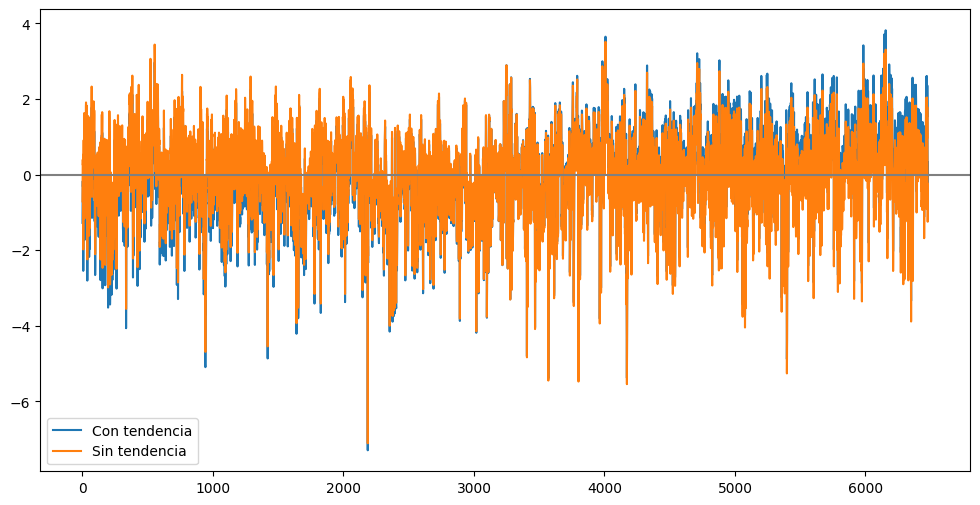

In [65]:
plt.figure(figsize=(12,6))
plt.plot(avg_anom.resample(time='2D').mean(),label='Con tendencia')
plt.plot(avg_anom_detr.resample(time='2D').mean(),label='Sin tendencia')
plt.legend()
plt.axhline(0,c='gray')

Aqui sí hay cambios importantes, ya que calculamos Tmean y std para las regiones específicas, que no es lo mismo que promediar en área las mismas cantidades.

In [66]:
def get_moving_mean_std(da):
    """
    Calcula la media móvil y la desviación estándar móvil de un DataArray de temperaturas, 
    útil por ejemplo para identificar eventos extremos como Cold Air Outbreaks (CAOs).

    Parámetros
    ----------
    da : xarray.DataArray
        Objeto de temperatura diaria (por ejemplo, 'tas') con una dimensión 'time'.

    Supuestos
    ---------
    - El DataArray debe tener coordenadas temporales con etiquetas 'time'.
    - Se espera que las fechas cubran varios años consecutivos para permitir el cálculo climatológico.

    Proceso
    -------
    1. Calcula la media anual del campo de temperatura.
    2. Calcula el ciclo anual (media diaria climatológica para cada día del año).
    3. Aplica una media móvil de 20 años centrada a la media anual, para suavizar tendencias.
    4. Calcula la desviación estándar móvil usando una ventana de 20 años con un mínimo de 15.

    Retorna
    -------
    tasclimyearsuavn : xarray.DataArray
        Media anual suavizada con una ventana móvil de 20 años (centrada).
    
    da_rolling_std : xarray.DataArray
        Desviación estándar móvil del DataArray original, usando la función `rolling_pooled_std`.

    Notas
    -----
    - La función `rolling_pooled_std` debe estar definida previamente en el mismo script o módulo.
    - Esta función es útil en contextos donde se desea identificar anomalías en temperatura
      respecto a una climatología móvil, como en el estudio de CAOs (Cold Air Outbreaks).
    """
    tas_climyearn = da.groupby('time.year').mean('time')
    tas_climdayn = da.groupby('time.dayofyear').mean('time')  # ciclo anual climatológico
    tasclimyearsuavn = tas_climyearn.rolling(year=20, center=True, min_periods=15).mean()
    da_rolling_std = rolling_pooled_std(da, window=20, min_periods=15)
    return tasclimyearsuavn, da_rolling_std


In [67]:
tas_tmean_norte,tas_std_norte=get_moving_mean_std(norte) #cuadrante norte

In [68]:
tasclimyearsuav_alineado = tasclimyearsuav.sel(lat=slice(22,27),lon=slice(255,262)).mean(dim=['lat','lon'])
tassuavstd_alineado = tassuavstd.sel(lat=slice(22,27),lon=slice(255,262)).mean(dim=['lat','lon'])
tas_std_alineado = tas_rolling_std.sel(lat=slice(22,27),lon=slice(255,262)).mean(dim=['lat','lon'])

Text(0.5, 1.0, 'Variacion de la temperatura promedio en HadGEM')

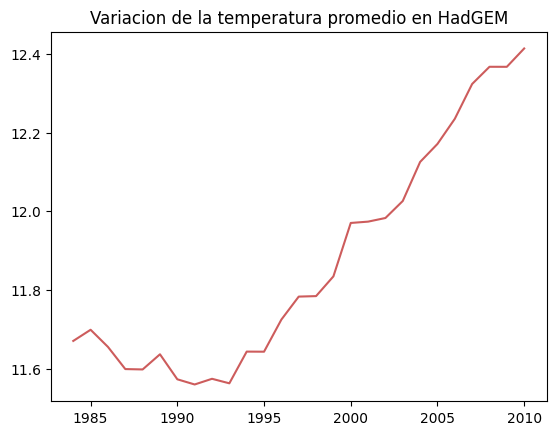

In [69]:
plt.plot(tasclimyearsuav_alineado.year,tasclimyearsuav_alineado,c='indianred')
plt.title('Variacion de la temperatura promedio en HadGEM')

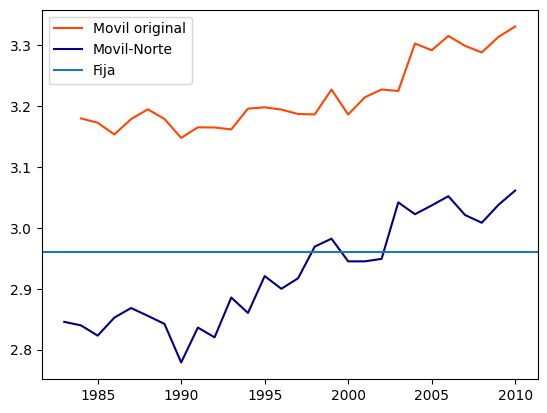

In [70]:
plt.plot(tasclimyearsuav_alineado.year,tassuavstd_alineado,c='orangered',label='Movil original')
plt.plot(tas_std_norte.year,tas_std_norte ,c='navy',label='Movil-Norte')
plt.axhline(norte.std('time'),label='Fija')
plt.legend()

Ahora si el calculo de CAOs, utilizando las temperaturas promedio y las desviaciones estandar obtenidas para la caja particular analizada. 

In [71]:
tas_tmean_norte

<xarray.DataArray 'tas' (year: 36)> Size: 288B
array([        nan,         nan,         nan,         nan,         nan,
       11.67695794, 11.70526157, 11.66171406, 11.60564828, 11.60466239,
       11.64303542, 11.57996626, 11.56710384, 11.58128676, 11.56951675,
       11.64995467, 11.64975056, 11.7311023 , 11.7891816 , 11.79030461,
       11.84033903, 11.97525044, 11.97875643, 11.98794708, 12.03117459,
       12.13040762, 12.1761612 , 12.23990895, 12.32809667, 12.37169552,
       12.37166879, 12.41804513,         nan,         nan,         nan,
               nan])
Coordinates:
    height   float64 8B 1.5
  * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014

Usando todos los nuevos objetos

In [77]:
def CAOS_MXgp(Tdias, mean_mv, std_mv):
    """
    Tdias son todos los días
    mean_mv es el promedio móvil para cada 10 años
    std_mv es la desviación estándar para cada 10 años
    """
    # Usar la temperatura suavizada (promedio móvil de 10 años)
    mean = mean_mv.values  # Temperaturas suavizadas (promedio móvil)
    desv_est = std_mv.values  # Desviación estándar suavizada (promedio móvil)
    years=mean_mv.year.values
    # Find the first index where value is not NaN
    first_valid_index = np.argmax(~np.isnan(mean))
    # Find the final where value is not NaN
    print(Tdias)
    
    init_year=years[first_valid_index]
    last_valid_index = np.where(~np.isnan(mean))[0][-1]
    print(last_valid_index)
    fyear=years[last_valid_index]
    print(init_year,fyear)
    dias_CAO = []
    temp_list = []
    print(len(Tdias))

    for i in range(0,len(Tdias)-1,1): 
        # Obtener el año del día actual
        year = Tdias['time'].dt.year[i]  # Año del día actual
        
        # Calcular el índice para la serie de 1979 a 2014
        index = year - init_year  # Calculamos el índice para la serie de 1979 a 2014
       # print(year.values)
        if year<init_year:
            index=first_valid_index
        if year>fyear:
            index=last_valid_index
            # 🔍 Find the index of the last non-NaN value
            
        # Verificar que el índice esté dentro del rango correcto
        if index < 0 or index >= len(mean):
            continue  # Si el índice está fuera de rango, se salta esa iteración
        
        # Obtener la temperatura media suavizada y la desviación estándar suavizada para el año correspondiente
        Tmean_suavizada = mean[index]  # Obtener el promedio para ese año
        try:
            Tstd_suavizada = desv_est[index]  # Desviación estándar para ese año
        except:
            last_stdindex = np.where(~np.isnan(std_mv))[0][-1]
            #print(year,index,last_stdindex)
            Tstd_suavizada = desv_est[last_stdindex]
            
        #print(Tstd_suavizada)
        # Condición de CAO con la temperatura suavizada y la desviación estándar suavizada
        condicionCAO = Tmean_suavizada - 2 * Tstd_suavizada
        #print(Tdias[i],condicionCAO)
        #print(Tdias['time'][i].values,float(Tdias[i]),float(condicionCAO))
        
        # Verificar si los días cumplen la condición de CAO (temperatura inferior al umbral)
        if Tdias[i] < condicionCAO and Tdias[i+1] < condicionCAO:
            dias_CAO.append(i)
            #print(Tdias[i],condicionCAO)
            #quit()
            dias_CAO.append(i + 1)
        #if i>10000:
        #    break
    print(Tdias.isel(time=dias_CAO).time)
    
    # Eliminar duplicados en los índices de días CAO
    dias_CAOS = list(set(dias_CAO))  # Eliminar duplicados, pero convertir en lista
    print(len(dias_CAOS))
    # Obtener las fechas correspondientes usando los índices
    dias_CAO_dates = Tdias['time'].values[dias_CAOS]  # Aquí accedes correctamente con los índices de días_CAOS
    
    # Convertir las fechas a un calendario gregoriano estándar 
    fechas_CAO_datetime = [pd.to_datetime(str(date)) for date in dias_CAO_dates]
    
    # Crear el diccionario con fechas y sus índices
    fechas_indices = {fecha: dias_CAOS[i] for i, fecha in enumerate(fechas_CAO_datetime)}
    # return fechas_CAO_datetime
    
    # Obtener las temperaturas de los días identificados como CAO
    for fecha, indice in fechas_indices.items():
        temperatura = Tdias[indice].values  # Obtener la temperatura del día indicado
        temp_list.append(temperatura)

    # Promedio de las temperaturas en los días CAO
    promedioT = np.mean(temp_list)
   
    return {'fechas': fechas_indices, 'temperaturas': temp_list, 'freq': len(dias_CAOS) / 36, 'promedioT': promedioT}

In [80]:
CAOsHG = CAOS_MXgp(norte,tas_tmean_norte,tas_std_norte) 
print(CAOsHG)
fechas_caoHG = CAOsHG['fechas']
temps = CAOsHG['promedioT']

<xarray.DataArray 'tas' (time: 3240)> Size: 26kB
array([11.97844226,  9.78454553, 11.81416627, ..., 11.71744229,
       11.06789016, 12.13596045])
Coordinates:
  * time     (time) object 26kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
    height   float64 8B 1.5
31
1984 2010
3240
<xarray.DataArray 'time' (time: 76)> Size: 608B
array([cftime.Datetime360Day(1979, 1, 12, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1979, 1, 13, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1979, 1, 13, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1979, 1, 14, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1981, 12, 21, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1981, 12, 22, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1983, 1, 25, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1983, 1, 26, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1983, 1, 26, 12, 0, 0, 0, has_y

In [81]:
temps #no es anomalía

4.41730749950767

In [113]:
# dataframeHG = pd.DataFrame(list(fechas_caoHG.items()), columns=["fecha", "indice"])

In [115]:
# dataframeHG.to_csv("datasets/fechasCAO_HG.csv", index=False)

In [53]:
CAOsHG2 = CAOS_MXgp(sur,tas_tmean_sur,tas_std_sur) 
fechas_caoHG2 = CAOsHG2['fechas']

<xarray.DataArray 'tas' (time: 3240)> Size: 26kB
array([14.69454309, 13.79170461, 15.08977733, ..., 15.20237293,
       15.5503213 , 15.97654816])
Coordinates:
  * time     (time) object 26kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
    height   float64 8B 1.5
31
1984 2010
3240
<xarray.DataArray 'time' (time: 54)> Size: 432B
array([cftime.Datetime360Day(1979, 12, 19, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1979, 12, 20, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1979, 12, 20, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1979, 12, 21, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1980, 2, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1980, 2, 3, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1980, 2, 3, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1980, 2, 4, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1983, 1, 6, 12, 0, 0, 0, has_year

TypeError: list indices must be integers or slices, not str

In [55]:
# codigo viejo
# CAOsHG = CAOS_MXgp(norte,tasclimyearsuav_alineado,tassuavstd_alineado) 
# fechas_caoHG = CAOsHG['fechas']

In [86]:
len(fechas_caoHG)

62

In [287]:
len(fechas_caoHG2)

42

In [117]:
indicesHG=[fechas_caoHG[key] for key in CAOsHG['fechas'].keys()]

In [119]:
indicesHG2=[fechas_caoHG2[key] for key in CAOsHG2['fechas'].keys()]

In [120]:
tempsHG = tas_inviernos.isel(time=indicesHG) #ESTA PARTE ES LA QUE YA VA A USAR EL CSV EN OTROS NOTEBOOKS

In [121]:
tempsHG2 = tas_inviernos.isel(time=indicesHG2)

In [122]:
tempsCAOHG=tempsHG.mean('time')
tempsCAOHG2=tempsHG2.mean('time')

In [123]:
anomaliaHG = tempsCAOHG - tas_djf

In [124]:
#VIENTO
u_et_caoHG = u_inviernosHG.isel(time=indicesHG)

In [125]:
vientoCAOHG = u_et_caoHG.mean('time')

In [126]:
u_anomaliaHG = vientoCAOHG - u_DJFHG

### **<font color="olive"> CAOs de ERA-5</font>**

In [56]:
def CAOS_MXgpE5(Tdias, mean_mv, std_mv):
    """
    Tdias son todos los días
    mean_mv es el promedio móvil para cada 10 años
    std_mv es la desviación estándar para cada 10 años
    """
    
    # Usar la temperatura suavizada (promedio móvil de 10 años)
    mean = mean_mv.values  # Temperaturas suavizadas (promedio móvil)
    desv_est = std_mv.values  # Desviación estándar suavizada (promedio móvil)
    years=mean_mv.year.values
    # Find the first index where value is not NaN
    first_valid_index = np.argmax(~np.isnan(mean))
    # Find the final where value is not NaN
    last_valid_index = np.argmax(np.isnan(mean))
    print(last_valid_index)
    init_year=years[first_valid_index]
    last_valid_index = np.where(~np.isnan(mean))[0][-1]
    fyear=years[last_valid_index]
    print(init_year,fyear)
    dias_CAO = []
    temp_list = []

    for i in range(len(Tdias)-1): 
        # Obtener el año del día actual
        year = Tdias['time'].dt.year[i]  # Año del día actual
        
        # Calcular el índice para la serie de 1979 a 2019
        index = year - 1979  # Calculamos el índice para la serie de 1979 a 2019
        # print(year.values)
        if year<init_year:
            index=first_valid_index
        elif year>fyear:
            index=last_valid_index
        # Verificar que el índice esté dentro del rango correcto
        if index < 0 or index >= len(mean):
            continue  # Si el índice está fuera de rango, se salta esa iteración
        
        # Obtener la temperatura media suavizada y la desviación estándar suavizada para el año correspondiente
        Tmean_suavizada = mean[index]  # Obtener el promedio para ese año
        try:
            Tstd_suavizada = desv_est[index]  # Desviación estándar para ese año
        except:
            last_stdindex = np.where(~np.isnan(std_mv))[0][-1]
            #print(year,index,last_stdindex)
            Tstd_suavizada = desv_est[last_stdindex]
        
        # Condición de CAO con la temperatura suavizada y la desviación estándar suavizada
        condicionCAO = Tmean_suavizada - 2 * Tstd_suavizada
        
        # Verificar si los días cumplen la condición de CAO (temperatura inferior al umbral)
        if Tdias[i] < condicionCAO and Tdias[i+1] < condicionCAO:
            #print(condicionCAO)
            dias_CAO.append(i)
            dias_CAO.append(i + 1)

    # Eliminar duplicados en los índices de días CAO
    dias_CAOS = list(set(dias_CAO))  # Eliminar duplicados, pero convertir en lista

    # Obtener las fechas correspondientes usando los índices
    dias_CAO_dates = Tdias['time'].values[dias_CAOS]  # Aquí accedes correctamente con los índices de días_CAOS
    
    # Convertir las fechas a un calendario gregoriano estándar 
    fechas_CAO_datetime = [pd.to_datetime(str(date)) for date in dias_CAO_dates]
    
    # Crear el diccionario con fechas y sus índices
    fechas_indices = {fecha: dias_CAOS[i] for i, fecha in enumerate(fechas_CAO_datetime)}
        
    # Obtener las temperaturas de los días identificados como CAO
    for fecha, indice in fechas_indices.items():
        temperatura = Tdias[indice].values  # Obtener la temperatura del día indicado
        temp_list.append(temperatura)

    # Promedio de las temperaturas en los días CAO
    promedioT = np.mean(temp_list)
   
    return {'fechas': fechas_indices, 'temperaturas': temp_list, 'freq': len(dias_CAOS) / 36, 'promedioT': promedioT}


In [58]:
#Elegir un cuadro de 4x4 (el mismo de las simulaciones)
mx_slicedE5 = t2m_inviernos.sel(latitude=slice(27,22)) 
mx_slicedE5 = mx_slicedE5.sel(longitude=slice(-105, -98)) 
mx_slicedE5

<xarray.DataArray 't2m' (time: 4152, latitude: 7, longitude: 10)> Size: 1MB
[290640 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 56B 27.0 26.25 25.5 24.75 24.0 23.25 22.5
  * longitude  (longitude) float64 80B -105.0 -104.2 -103.5 ... -99.0 -98.25
  * time       (time) datetime64[ns] 33kB 1979-01-01 1979-01-02 ... 2024-12-31
    number     int64 8B ...
    surface    float64 8B ...

In [59]:
#Elegir un cuadro de 4x4 (el mismo de las simulaciones)
mx_slicedE52 = t2m_inviernos.sel(latitude=slice(22,17)) 
mx_slicedE52 = mx_slicedE52.sel(longitude=slice(-105, -98)) 

In [60]:
weights = np.cos(np.deg2rad(mx_slicedE5.latitude))
weights.name = "weights"

In [61]:
weights2 = np.cos(np.deg2rad(mx_slicedE52.latitude))
weights2.name = "weights"

In [62]:
t2m_weighted = mx_slicedE5.weighted(weights)

In [63]:
t2m_weighted2 = mx_slicedE52.weighted(weights2)

In [64]:
norteE5 = t2m_weighted.mean(['longitude','latitude']) #promedio a variable ya pesada

+ Graficas para claridad.
+ Se pueden borrar

In [65]:
t2m_climyearn = norteE5.groupby('time.year').mean('time')
t2m_climdayn = norteE5.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

t2mclimyearsuavn = t2m_climyearn.rolling(year=20, center=True, min_periods=15).mean()
t2mclimdaysuavn = t2m_climdayn.rolling(dayofyear=11, center=True, min_periods=1).mean()

anomaliasdaynE5 = norteE5.groupby('time.dayofyear') - t2mclimdaysuavn
anomaliasdaynE5_detrend = detrend_dataarray_preserve_mean(anomaliasdaynE5, dim='time')

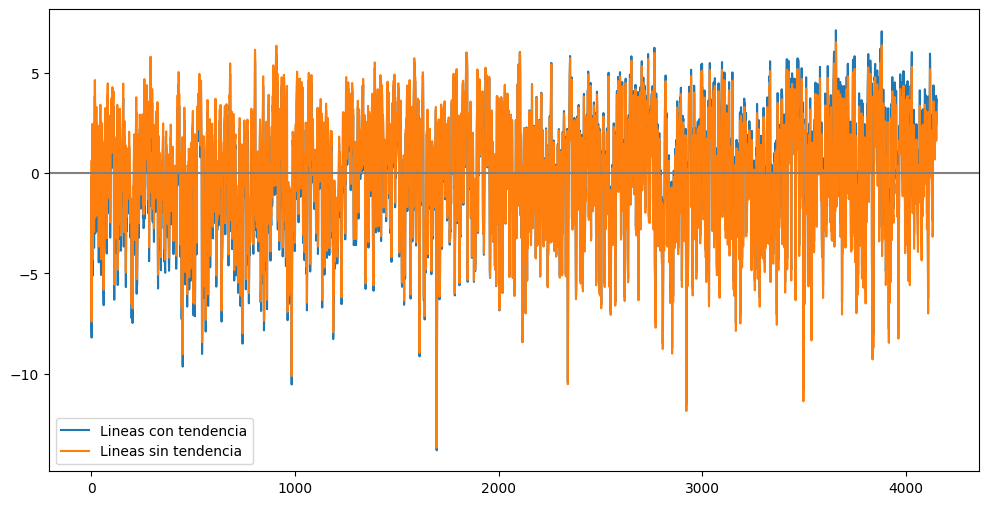

In [66]:
plt.figure(figsize=(12,6))
plt.plot(anomaliasdaynE5,label='Lineas con tendencia')
plt.plot(anomaliasdaynE5_detrend,label='Lineas sin tendencia')
plt.axhline(0,c='gray')
plt.legend()

Calculo de CAOS en region norte y sur

In [67]:
surE5 = t2m_weighted2.mean(['longitude','latitude']) #promedio a variable ya pesada

In [68]:
t2m_tmean_sur,t2m_std_sur=get_moving_mean_std(surE5)
t2m_tmean_norte,t2m_std_norte=get_moving_mean_std(norteE5)

In [69]:
CAOsE5 = CAOS_MXgpE5(norteE5,t2m_tmean_norte,t2m_std_norte) 
fechas_caoE5= CAOsE5['fechas']

0
1984 2020


In [70]:
# dataframeE5 = pd.DataFrame(list(fechas_caoE5.items()), columns=["fecha", "indice"])

In [71]:
# dataframeE5.to_csv("datasetsok/fechasCAO_E5.csv", index=False)

In [72]:
CAOsE5sur = CAOS_MXgpE5(surE5,t2m_tmean_sur,t2m_std_sur) 
fechas_caoE5sur= CAOsE5sur['fechas']

0
1984 2020


In [73]:
len(fechas_caoE5)

70

In [ ]:
#t2mclimyearsuav_alineado = t2mclimyearsuav.sel(latitude=slice(27,22),longitude=slice(255,262)).weighted(weights).mean(dim=['latitude','longitude'])
#t2msuavstd_alineado = t2msuavstd.sel(latitude=slice(27,22),longitude=slice(255,262)).weighted(weights).mean(dim=['latitude','longitude'])

In [ ]:
#t2mclimyearsuav_alineado2 = t2mclimyearsuav.sel(latitude=slice(22,17),longitude=slice(255,262)).weighted(weights2).mean(dim=['latitude','longitude'])
#t2msuavstd_alineado2 = t2msuavstd.sel(latitude=slice(22,17),longitude=slice(255,262)).weighted(weights2).mean(dim=['latitude','longitude'])

In [ ]:
#CAOsE5 = CAOS_MXgpE5(norteE5,t2mclimyearsuav_alineado,t2msuavstd_alineado) 
#fechas_caoE5= CAOsE5['fechas']

In [ ]:
#CAOsE5 = CAOS_MXgpE5(norteE5,t2mclimyearsuav_alineado,t2msuavstd_alineado) 
#fechas_caoE5= CAOsE5['fechas']

In [74]:
newt=[]
for fecha in fechas_caoE5.keys():
    newt.append(fecha)

In [75]:
newt_hg=[]
for fecha in fechas_caoHG.keys():
    newt_hg.append(fecha)

NameError: name 'fechas_caoHG' is not defined

In [76]:
len(fechas_caoE5)

70

In [77]:
len(fechas_caoE5sur)

106

In [78]:
E5_listindex=[fechas_caoE5[key] for key in CAOsE5['fechas'].keys()]

In [79]:
# E5_listindexn=[fechas_caoE5n[key] for key in CAOsE5['fechas'].keys()]

In [82]:
E5_listindex2=[fechas_caoE5sur[key] for key in CAOsE5sur['fechas'].keys()]

In [83]:
tempsE5 = t2m_inviernos.isel(time=E5_listindex)

In [84]:
# tempsE5n = t2m_inviernos.isel(time=E5_listindexn)

In [85]:
tempsE52 = t2m_inviernos.isel(time=E5_listindex2)

In [86]:
tempsCAOE5=tempsE5.mean('time')
# tempsCAOE5 #es el promedio del total de CAOS

In [87]:
tempsCAOE52=tempsE52.mean('time')
# tempsCAOE52 #es el promedio del total de CAOS en el sur

In [89]:
E5_anomalia=tempsCAOE5-t2m_inviernos

In [100]:
u_et_caoE5 = u_inviernosE5.isel(time=E5_listindex)

In [101]:
vientoCAOE5 = u_et_caoE5.mean('time')

In [103]:
u_anomaliaE5 = vientoCAOE5 - u_inviernosE5

##### **<font color="olive"> MÉTODO 1. Ciclo anual temperatura </font>**

In [104]:
# anomaliasday_detrend['time']=anomaliasday_detrend.indexes['time'].to_datetimeindex()

In [105]:
anomaliasday_detrend

<xarray.DataArray (lat: 36, lon: 37, time: 12960)> Size: 69MB
array([[[-7.1485084e-01, -7.0361918e-01, -6.8670166e-01, ...,
          6.7995155e-01,  8.4775752e-01,  1.0776973e+00],
        [-4.9332902e-01, -4.5003197e-01, -5.7901239e-01, ...,
          5.0482988e-01,  9.5483661e-01,  1.1345301e+00],
        [-6.0576469e-01, -4.3852100e-01, -7.8572738e-01, ...,
          5.6331527e-01,  1.0188643e+00,  1.0480597e+00],
        ...,
        [-4.1597179e-01, -5.7927430e-01,  6.7107564e-01, ...,
         -6.7890149e-01,  2.3128997e-01,  3.8859370e-01],
        [-3.4631437e-01, -3.0053189e-01,  5.6371677e-01, ...,
          3.4397709e-01,  1.6149411e+00,  1.5423115e+00],
        [-4.2967972e-01, -3.2985446e-01,  3.9918986e-01, ...,
         -2.2564784e-01,  1.2249515e-01,  1.9722734e-01]],

       [[-6.2208188e-01, -7.5404495e-01, -3.4263489e-01, ...,
          4.6023819e-01,  3.9538711e-01,  8.2670224e-01],
        [-6.2572479e-01, -5.1312476e-01, -3.4326807e-01, ...,
          3.4368005e-01,  3.2933265e-01,  7.6303291e-01],
        [-6.6789913e-01, -7.0233762e-01, -3.5995269e-01, ...,
          2.0300078e-01,  3.2152975e-01,  7.2844791e-01],
...
        [-5.7742734e+00, -1.3337875e+01, -8.7802782e+00, ...,
          5.0328050e+00,  1.3484293e+01,  8.3865175e+00],
        [-3.4296679e+00, -1.1534057e+01, -1.0262638e+01, ...,
          2.8895967e+00,  1.3774237e+01,  7.7873855e+00],
        [-6.4843240e+00, -6.3117614e+00, -2.3857340e-01, ...,
          2.2955544e+00,  7.8159804e+00,  2.9715648e+00]],

       [[-2.2328842e+00, -9.8517334e-01,  9.1566078e-02, ...,
         -4.4332123e-01, -1.4258393e+00, -7.3375207e-01],
        [-1.4555312e+00, -1.1733961e+00, -1.8347058e-01, ...,
         -1.1661936e+00, -1.8308024e+00, -1.5853490e+00],
        [-9.3686569e-01, -7.3080522e-01, -1.3083246e-01, ...,
         -1.6769807e+00, -2.2088535e+00, -1.6260163e+00],
        ...,
        [-4.3047295e+00, -1.3064759e+01, -7.5600319e+00, ...,
          4.9824085e+00,  1.7830141e+01,  1.1573639e+01],
        [-3.0841444e+00, -1.2099791e+01, -8.5064812e+00, ...,
          1.1897014e+00,  1.7589195e+01,  1.1946598e+01],
        [-6.0529246e+00, -6.6369019e+00, -2.8976698e+00, ...,
          3.2967606e+00,  9.1784801e+00,  4.9895482e+00]]], dtype=float32)
Coordinates:
  * time       (time) object 104kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lon        (lon) float64 296B 227.8 229.7 231.6 233.4 ... 291.6 293.4 295.3
  * lat        (lat) float64 288B 5.625 6.875 8.125 9.375 ... 46.88 48.12 49.38
    height     (time) float64 104kB 1.5 1.5 1.5 1.5 1.5 ... 1.5 1.5 1.5 1.5 1.5
    dayofyear  (time) int64 104kB 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360

In [112]:
# HADGEM --------------
tempsHGday = anomaliasday_detrend_djf.isel(time=indicesHG) 
# anomalias con tiempos, que chance no funcione para HADGEM --------------
#tempsHGdayn = anomaliasday_detrend.sel(time=newt_hg) 
# ERA ---------------------
tempsE5day = anomaliasdayE5.isel(time=E5_listindex)
# se recomienda usar los datos sin tendencia y para djf
tempsE5day = anomaliasdayE5_detr_djf.isel(time=E5_listindex)

##### **<font color="olive"> MÉTODO 2. Estacionalidad temperatura </font>**

In [113]:
# HADGEM --------------
tempsHG = tas_inviernos.isel(time=indicesHG)
tempsCAOHG = tempsHG.mean('time') #temperatura promedio en CAOs
tempsHGday_mean = tempsHGday.mean('time') #este ya se mapea 
anomaliaHG = tempsCAOHG - tas_djf #este ya se mapea

# ERA ---------------------

tempsE5 = t2m_inviernos.isel(time=E5_listindex)
tempsCAOE5=tempsE5.mean('time') # temperatura promedio en CAOs, falta anomalía
tempsE5day_mean = tempsE5day.mean('time') #este ya se mapea 
# tempsE5day_meann = tempsE5dayn.mean('time') #este ya se mapea
anomaliaE5 = tempsCAOE5 - t2m_inviernos #este ya se mapea 

##### **<font color="olive"> MÉTODO 1. Ciclo anual viento </font>**

In [114]:
# HADGEM --------------
usHGday = uanomaliasday_djf.isel(time=indicesHG) 
# ERA ---------------------
usE5day = uanomaliasdayE5.isel(time=E5_listindex) 

##### **<font color="olive"> MÉTODO 2. Estacionalidad viento </font>**

In [117]:
# HADGEM -----------
usHG = u_inviernosHG.isel(time=indicesHG)
usCAOHG = usHG.mean('time') #viento promedio en CAOs
usHGday_mean = usHGday.mean('time') #este ya se mapea 
uanomaliaHG = usCAOHG - u_DJFHG #este ya se mapea

# ERA5 ----------------
usE5 = u_inviernosE5.isel(time=E5_listindex)
usCAOE5 = usE5.mean('time') # viento promedio en CAOs, falta anomalía
usE5day_mean = usE5day.mean('time') #este ya se mapea 
uanomaliaE5 = usCAOE5 - u_inviernosE5 #este ya se mapea 

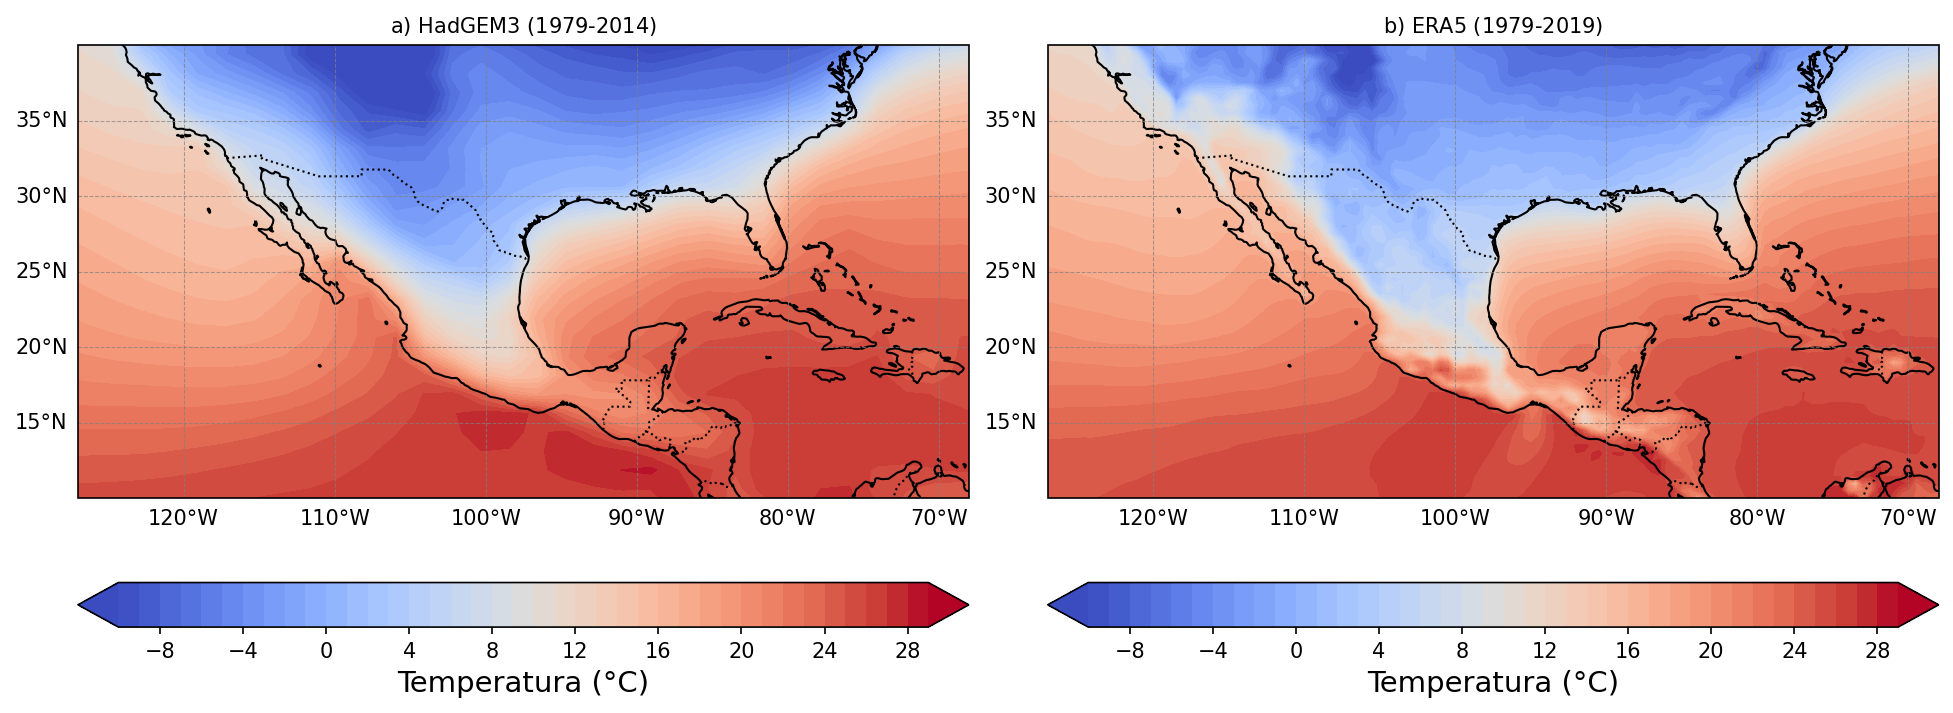

In [174]:
# Usar constrained_layout en lugar de tight_layout
fig, axes = plt.subplots(1, 2, figsize=(13, 6), dpi=150, subplot_kw={'projection': ccrs.PlateCarree()})#, constrained_layout=True)

# Subplot 1 - HadGEM3
ax1 = axes[0]
ax1.coastlines()
cs1 = ax1.contourf(tempsCAOHG.lon, tempsCAOHG.lat, tempsCAOHG, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax1.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())

gl1 = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl1.top_labels = gl1.right_labels = False
ax1.tick_params(labelsize=12)
ax1.set_title('a$)$ HadGEM3 (1979-2014)', fontsize=10)

# Subplot 2 - ERA5
ax2 = axes[1]
ax2.coastlines()
cs2 = ax2.contourf(tempsCAOE5.longitude, tempsCAOE5.latitude, tempsCAOE5, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax2.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())

gl2 = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl2.top_labels = gl2.right_labels = False
ax2.tick_params(labelsize=12) 
ax2.set_title('b$)$ ERA5 (1979-2019)', fontsize=10)

# Colorbar único
cbar = fig.colorbar(cs2, ax=ax1, orientation='horizontal', fraction=0.09, pad=0.1)
cbar.ax.set_xlabel('Temperatura (°C)', fontsize=14)
cbar = fig.colorbar(cs1, ax=ax2, orientation='horizontal', fraction=0.09, pad=0.1)
cbar.ax.set_xlabel('Temperatura (°C)', fontsize=14)

# Ajustes finales
fig.subplots_adjust(top=0.95)  # Espacio para el título principal
# fig.set_constrained_layout_pads(w_pad=1)#, h_pad=0.5)
fig.tight_layout(pad=0.5,w_pad=0.5)
# fig.suptitle('Temperatura superficial durante eventos CAO', fontsize=14, color="k", fontstyle='italic', fontweight='bold')

# Guardar figura
plt.savefig("figs/TmeanCAO.png", bbox_inches='tight')

plt.show()


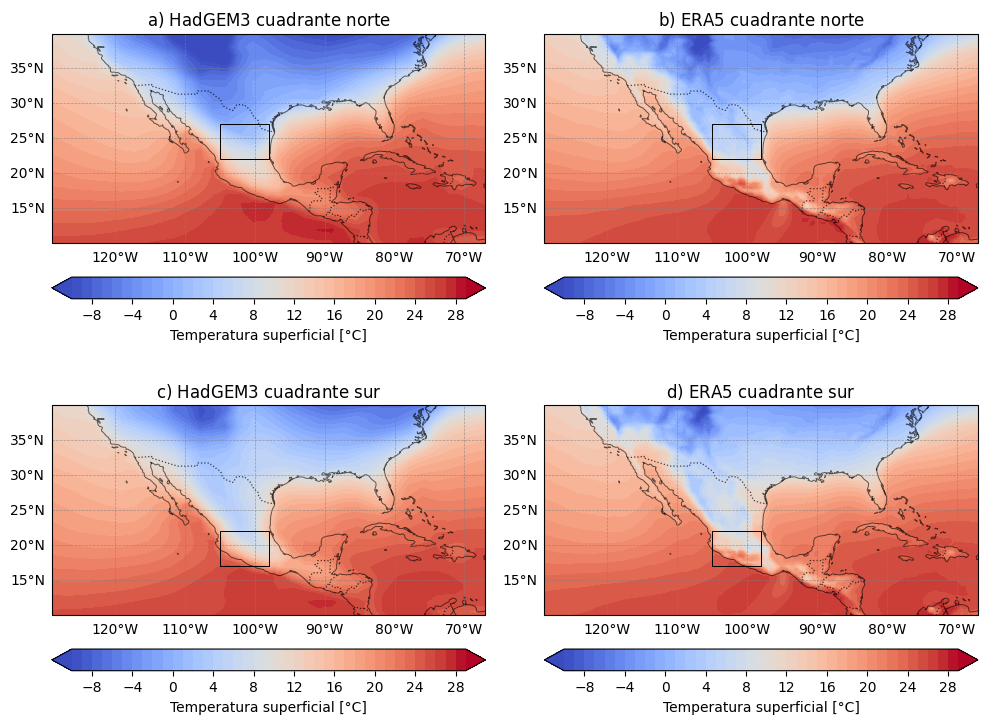

In [391]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.2, hspace=0.35)
axs = axs.flatten()

# MÉTODO 1: SIN CICLO ANUAL HG ( YA OK ) -------------------------------------------------------------------------------------------
ax = axs[0]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(tempsCAOHG.lon, tempsCAOHG.lat, tempsCAOHG, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
rect = patches.Rectangle((255, 22), 262-255, 27-22, 
                         linewidth=0.7, edgecolor='black', facecolor='none', 
                         transform=ccrs.PlateCarree(), zorder=10)
ax.add_patch(rect)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('a$)$ HadGEM3 cuadrante norte', fontsize=12)

# MÉTODO 1: SIN CICLO ANUAL E5 ( YA OK ) -------------------------------------------------------------------------------------------
ax = axs[1]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(tempsCAOE5.longitude, tempsCAOE5.latitude, tempsCAOE5, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
rect2 = patches.Rectangle((255, 22), 262-255, 27-22, 
                         linewidth=0.7, edgecolor='black', facecolor='none', 
                         transform=ccrs.PlateCarree(), zorder=10)
ax.add_patch(rect2)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('b$)$ ERA5 cuadrante norte', fontsize=12)

# MÉTODO 2: CICLO ANUAL HG  -------------------------------------------------------------------------------------------
ax = axs[2]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(tempsCAOHG2.lon, tempsCAOHG2.lat, tempsCAOHG2, levels=np.arange(-10,30,1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
rect3 = patches.Rectangle((255, 17), 262-255, 22-17, 
                         linewidth=0.7, edgecolor='black', facecolor='none', 
                         transform=ccrs.PlateCarree(), zorder=10)
ax.add_patch(rect3)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('c$)$ HadGEM3 cuadrante sur', fontsize=12)

# MÉTODO 2: CICLO ANUAL E5 -------------------------------------------------------------------------------------------
ax = axs[3]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(tempsCAOE52.longitude, tempsCAOE52.latitude, tempsCAOE52, levels=np.arange(-10,30,1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
rect4 = patches.Rectangle((255, 17), 262-255, 22-17, 
                         linewidth=0.7, edgecolor='black', facecolor='none', 
                         transform=ccrs.PlateCarree(), zorder=10)
ax.add_patch(rect4)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('d$)$ ERA5 cuadrante sur', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=.95)
# plt.suptitle('Temperatura durante eventos CAO en dos cuadrantes',fontsize=14,color="k",fontstyle='italic',fontweight='bold');


plt.savefig('figs/6_TmeanCAO_NyS')

##### **<font color="olive"> ESTE VA A SER PARA ANOMALÍAS!!!!!!!! </font>**

In [378]:
anomaliaNHG = tempsCAOHG - tas_djf
anomaliaNE5 = tempsCAOE5 - invs_E5
anomaliaSHG = tempsCAOHG2 - tas_djf
anomaliaSE5 = tempsCAOE5 - invs_E5S

In [379]:
np.max(anomaliaNE5)

<xarray.DataArray 't2m' ()> Size: 8B
array(1.12131705)
Coordinates:
    season   <U3 12B 'DJF'

In [146]:
# df = pd.read_csv("datasets/fechasCAO_E5.csv")

# # Convertir la columna 'fecha' a solo la fecha (sin hora)
# df['fecha'] = pd.to_datetime(df['fecha']).dt.date

# # Guardar el DataFrame de nuevo en un CSV
# df.to_csv("datasets/fechasCAOs_E5.csv", index=False)

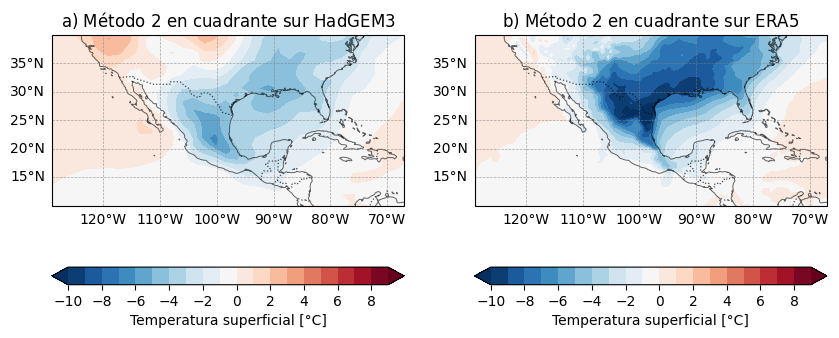

In [380]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.2, hspace=0.35)
axs = axs.flatten()

# MÉTODO 1: SIN CICLO ANUAL HG ( YA OK ) -------------------------------------------------------------------------------------------
# ax = axs[0]
# ax.coastlines(linewidth=0.7,alpha=0.6)
# cs = ax.contourf(anomaliaNHG.lon, anomaliaNHG.lat, anomaliaNHG, levels=np.arange(-10, 10, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
# ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
# rect = patches.Rectangle((255, 22), 262-255, 27-22, 
#                          linewidth=0.7, edgecolor='black', facecolor='none', 
#                          transform=ccrs.PlateCarree(), zorder=10)
# ax.add_patch(rect)
# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
# gl.top_labels = gl.right_labels = False
# plt.minorticks_on()
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
# cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
# ax.set_title('a$)$ HadGEM3 cuadrante norte', fontsize=12)

# # MÉTODO 1: SIN CICLO ANUAL E5 ( YA OK ) -------------------------------------------------------------------------------------------
# ax = axs[1]
# ax.coastlines(linewidth=0.7,alpha=0.6)
# cs = ax.contourf(anomaliaNE5.longitude, anomaliaNE5.latitude, anomaliaNE5, levels=np.arange(-10, 10, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
# ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
# rect2 = patches.Rectangle((255, 22), 262-255, 27-22, 
#                          linewidth=0.7, edgecolor='black', facecolor='none', 
#                          transform=ccrs.PlateCarree(), zorder=10)
# ax.add_patch(rect2)
# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
# gl.top_labels = gl.right_labels = False
# plt.minorticks_on()
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
# cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
# ax.set_title('b$)$ ERA5 cuadrante norte', fontsize=12)

# MÉTODO 2: CICLO ANUAL HG  -------------------------------------------------------------------------------------------
ax = axs[0]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(anomaliaSHG.lon, anomaliaSHG.lat, anomaliaSHG, levels=np.arange(-10,10,1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
# rect3 = patches.Rectangle((255, 17), 262-255, 22-17, 
#                          linewidth=0.7, edgecolor='black', facecolor='none', 
#                          transform=ccrs.PlateCarree(), zorder=10)
# ax.add_patch(rect3)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('a$)$ Método 2 en cuadrante sur HadGEM3', fontsize=12)

# MÉTODO 2: CICLO ANUAL E5 -------------------------------------------------------------------------------------------
ax = axs[1]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(anomaliaSE5.longitude, anomaliaSE5.latitude, anomaliaSE5, levels=np.arange(-10,10,1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
# rect4 = patches.Rectangle((255, 17), 262-255, 22-17, 
#                          linewidth=0.7, edgecolor='black', facecolor='none', 
#                          transform=ccrs.PlateCarree(), zorder=10)
# ax.add_patch(rect4)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('b$)$ Método 2 en cuadrante sur ERA5', fontsize=12)

# plt.tight_layout()
# plt.subplots_adjust(top=.95)
# plt.suptitle('Temperatura durante eventos CAO en dos cuadrantes',fontsize=14,color="k",fontstyle='italic',fontweight='bold');


plt.savefig('figs/61_TanomaliaCAO_NyS')

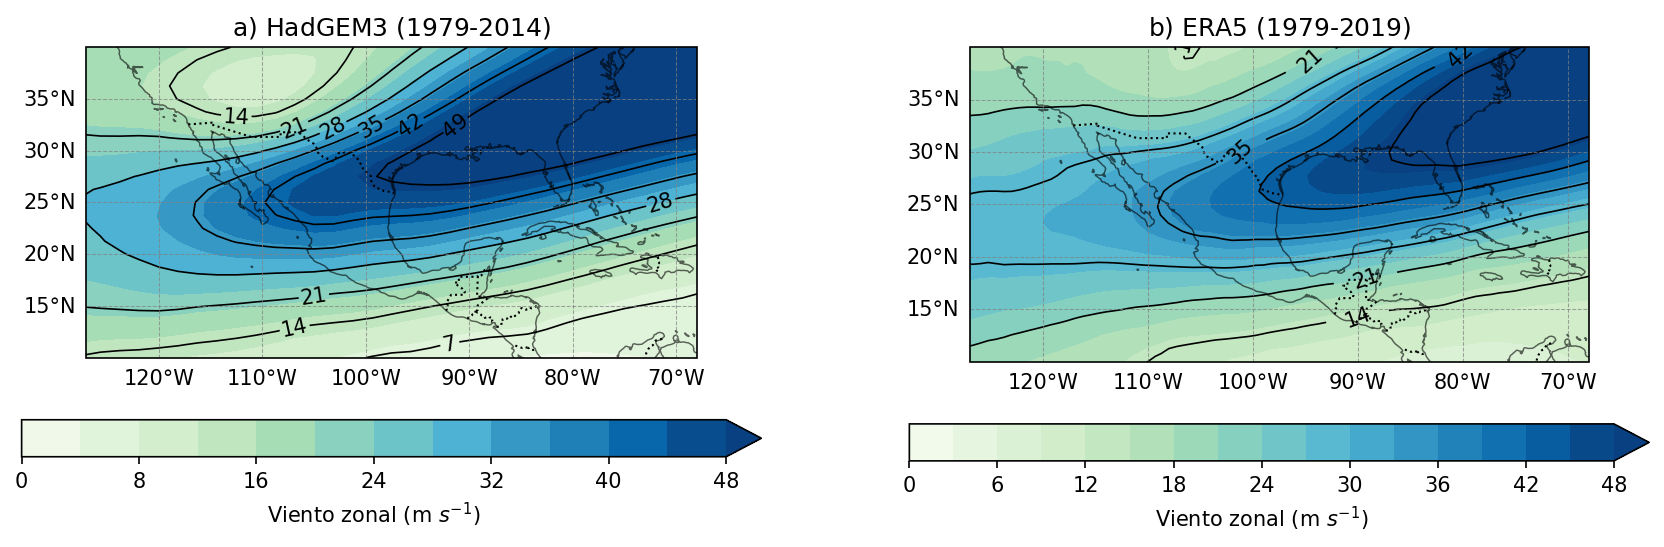

In [381]:
# Crear figura
fig = plt.figure(figsize=(14, 4), dpi=150)
fig.set_constrained_layout_pads(w_pad=1.0, h_pad=0.5)  # Reduce el espacio entre gráficos

# Subplot 1
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.coastlines(linewidth=0.7, alpha=0.6)
cs = ax1.contourf(usCAOHG.lon, usCAOHG.lat, usCAOHG, levels=np.arange(0, 50, 4), cmap='GnBu', extend='max', transform=ccrs.PlateCarree())
cc = ax1.contour(usCAOHG.lon, usCAOHG.lat, usCAOHG, levels=np.arange(0, 50, 7), colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
ax1.clabel(cc, cc.levels, inline=True, fontsize=10)
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax1.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=10)
plt.title('a$)$ HadGEM3 (1979-2014)', fontsize=12)

# Subplot 2
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.coastlines(linewidth=0.7, alpha=0.6)
cs = ax2.contourf(usCAOE5.longitude, usCAOE5.latitude, usCAOE5, levels=np.arange(0, 50, 3), cmap='GnBu', extend='max', transform=ccrs.PlateCarree())
cc = ax2.contour(usCAOE5.longitude, usCAOE5.latitude, usCAOE5, levels=np.arange(0, 50, 7), colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
ax2.clabel(cc, cc.levels, inline=True, fontsize=10)
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax2.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.09, ax=ax2)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=10)
plt.title('b$)$ ERA5 (1979-2019)', fontsize=12)

# Ajustes finales
plt.subplots_adjust(top=0.8)
# plt.suptitle('Viento zonal promedio a 200 hPa durante eventos CAO', fontsize=14, color="k", fontstyle='italic', fontweight='bold')
plt.savefig("figs/8_VmeanCAO.png", bbox_inches='tight')


###### <h1  style="color:purple; font-size:20px;"><i> Climatología de temperatra superficial en CAOS con dos métodos </i> </h1>

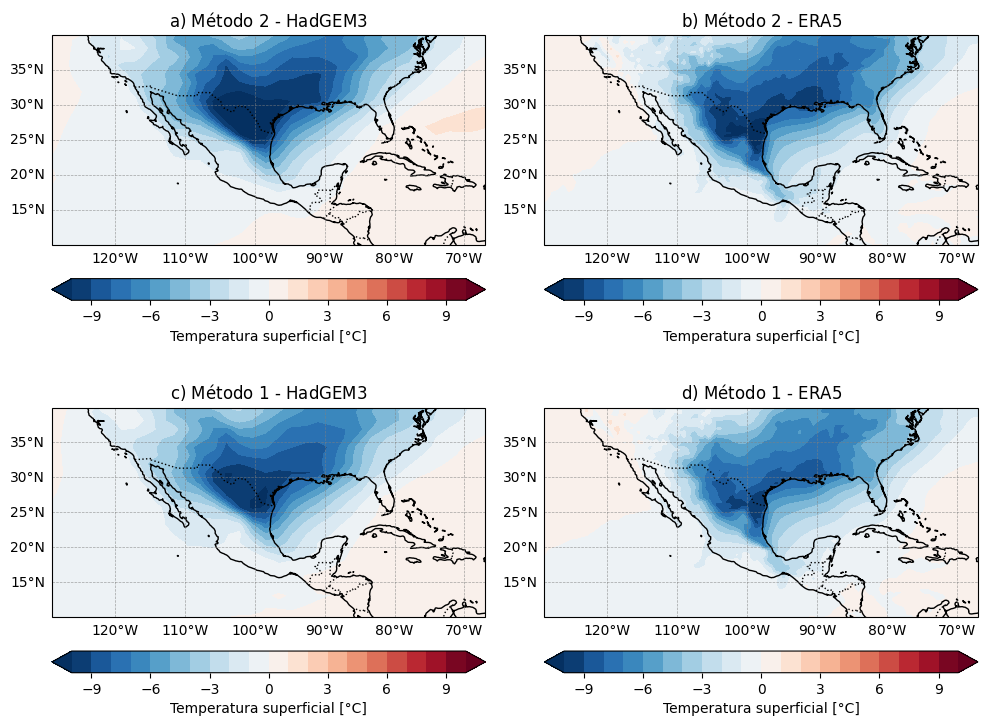

In [384]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.2, hspace=0.35)
axs = axs.flatten()

# MÉTODO 1: SIN CICLO ANUAL HG ( YA OK ) -------------------------------------------------------------------------------------------
ax = axs[0]
ax.coastlines()
cs = ax.contourf(anomaliaHG .lon, anomaliaHG.lat, anomaliaHG, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('a$)$ Método 2 - HadGEM3', fontsize=12)

# MÉTODO 1: SIN CICLO ANUAL E5 ( YA OK ) -------------------------------------------------------------------------------------------
ax = axs[1]
ax.coastlines()
cs = ax.contourf(anomaliaE5.longitude, anomaliaE5.latitude, anomaliaE5, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('b$)$ Método 2 - ERA5', fontsize=12)

# MÉTODO 2: CICLO ANUAL HG  -------------------------------------------------------------------------------------------
ax = axs[2]
ax.coastlines()
cs = ax.contourf(tempsHGday_mean.lon, tempsHGday_mean.lat, tempsHGday_mean, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('c$)$ Método 1 - HadGEM3', fontsize=12)

# MÉTODO 2: CICLO ANUAL E5 -------------------------------------------------------------------------------------------
ax = axs[3]
ax.coastlines()
cs = ax.contourf(tempsE5day_mean.longitude, tempsE5day_mean.latitude, tempsE5day_mean, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=10)
ax.set_title('d$)$ Método 1 - ERA5', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=.95)
# plt.suptitle('Anomalías de temperatura durante eventos CAO',fontsize=14,color="k",fontstyle='italic',fontweight='bold');


plt.savefig('figs/7_metodosCAO')

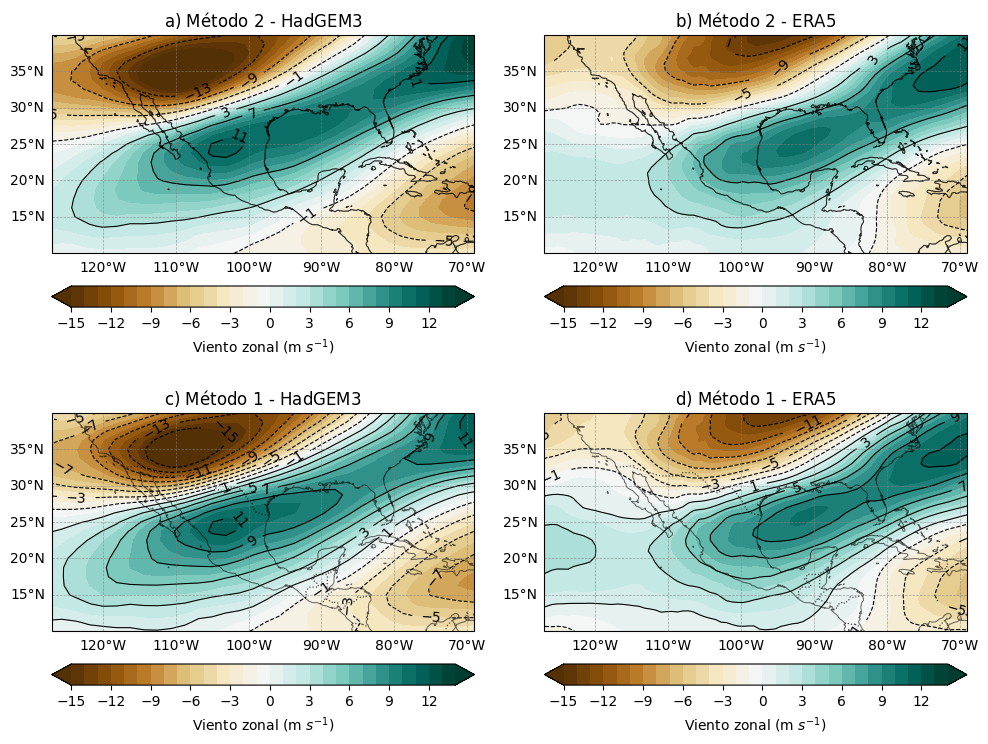

In [392]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.2, hspace=0.35)
axs = axs.flatten()


# MÉTODO 1: SIN CICLO ANUAL HG ( YA OK ) -------------------------------------------------------------------------------------------
ax = axs[0]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(uanomaliaHG.lon, uanomaliaHG.lat, uanomaliaHG, levels=np.arange(-15, 15, 1), cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cc=ax.contour(uanomaliaHG.lon, uanomaliaHG.lat, uanomaliaHG, levels=np.arange(-13, 13, 4),colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.coastlines(linewidth=0.7,alpha=0.6)
ax.set_extent([233, 291, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=10)
ax.set_title('a$)$ Método 2 - HadGEM3', fontsize=12)


# MÉTODO 1: SIN CICLO ANUAL E5 ( YA OK ) -------------------------------------------------------------------------------------------
ax = axs[1]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(uanomaliaE5.longitude, uanomaliaE5.latitude, uanomaliaE5, levels=np.arange(-15, 15, 1), cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cc=ax.contour(uanomaliaE5.longitude, uanomaliaE5.latitude, uanomaliaE5, levels=np.arange(-13, 13, 4),colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.coastlines(linewidth=0.7,alpha=0.6)
ax.set_extent([233, 291, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=10)
ax.set_title('b$)$ Método 2 - ERA5', fontsize=12)

# MÉTODO 2: CICLO ANUAL HG  -------------------------------------------------------------------------------------------
ax = axs[2]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(usHGday_mean .lon, usHGday_mean .lat, usHGday_mean, levels=np.arange(-15, 15, 1), cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cc=ax.contour(usHGday_mean .lon, usHGday_mean .lat, usHGday_mean, levels=np.arange(-15, 15, 2),colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([233, 291, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=10)
ax.set_title('c$)$ Método 1 - HadGEM3', fontsize=12)

# MÉTODO 2: CICLO ANUAL E5 -------------------------------------------------------------------------------------------
ax = axs[3]
ax.coastlines(linewidth=0.7,alpha=0.6)
cs = ax.contourf(usE5day_mean.longitude, usE5day_mean.latitude, usE5day_mean, levels=np.arange(-15, 15, 1), cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cc=ax.contour(usE5day_mean.longitude, usE5day_mean.latitude, usE5day_mean,levels=np.arange(-15, 15, 2),colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.set_extent([233, 291, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=10)
ax.set_title('d$)$ Método 1 - ERA5', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=.95)
# plt.suptitle('Viento zonal durante eventos CAO',fontsize=14,color="k",fontstyle='italic',fontweight='bold');


plt.savefig('figs/9_metodosCAOyviento')
